In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.neighbors import NearestNeighbors

## Create lorentz time series

In [2]:
# Parameters
T=4000 #sequence size
sigma=10
beta=8/3
rho=28
dt=0.01

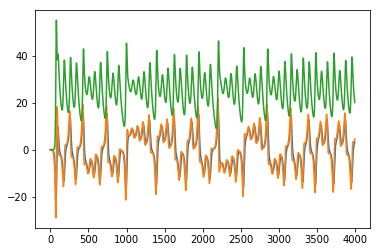

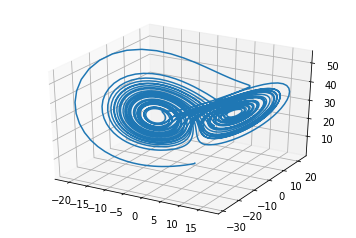

In [3]:
x=np.zeros((T+1))
y=np.zeros((T+1))
z=np.zeros((T+1))
x[0]=0.2*(np.random.rand()-0.5)
y[0]=0.2*(np.random.rand()-0.5)
z[0]=0.2*(np.random.rand()-0.5)

for i in range(T):
    x[i+1]=x[i]+dt*sigma*(y[i]-x[i])
    y[i+1]=y[i]+dt*(x[i]*(rho-z[i])-y[i])
    z[i+1]=z[i]+dt*(x[i]*y[i]-beta*z[i])

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(x)
ax.plot(y)
ax.plot(z)

fig2=plt.figure()
ax2=fig2.add_subplot(111,projection='3d')
ax2.plot(x,y,z)

### Create shadow manifold for X,Y and Z

In [4]:
E=3
tau=2
L=5 # number of samples from the time series sequence

In [5]:
def build_shadow_M (X,tau,E,T):
    '''Build the shadow manifold of the time series signal X, with E variables and sampling tau'''
    shadow_M=np.zeros((T-E+1,E))
    for i in range((tau*E-1),T):
        sample=np.zeros((E))
        for j in range(0,E):
            sample[j]=x[i-j*tau]
        shadow_M[i-(tau*E-1),:]=sample
    return shadow_M

In [6]:
shadow_x=build_shadow_M(x,tau,E,T)
shadow_y=build_shadow_M(y,tau,E,T)
shadow_z=build_shadow_M(z,tau,E,T)

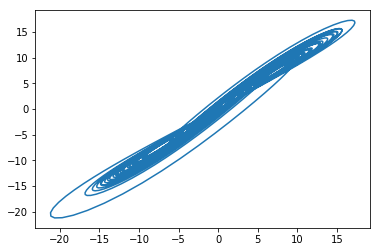

In [7]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot(shadow_x[:,0],shadow_x[:,1],shadow_x[:,2])

fig = plt.figure()
plt.plot(shadow_x[:,0],shadow_x[:,1])

### Sample the random manifold
Selec the value L, that reflects the number of points of the reconstructed manifold

In [89]:
L=10
def sample_manifold (M, L):
    '''Randomly select L points from the shadow manifold M'''
    new_M=np.zeros((L,M.shape[1]))
    idx=np.random.randint(M.shape[0], size=L)
    for i in range(L):
        new_M[i,:]=M[idx[i],:]
    return new_M, idx
            

In [90]:
recon_Mx, idx_x=sample_manifold(shadow_x,L)
recon_My, idx_y=sample_manifold(shadow_y,L)
recon_Mz, idx_z=sample_manifold(shadow_z,L)

In [91]:
idx_x

array([  22, 1798, 3263, 1449,  270, 1047,  374, 1793, 1910,  132])

### Find E+1 nearest neighbors

In [92]:
def nearest_points(M,idx,E):
    '''Find the E+2 nearest points to each point in the reconstructed manifold, it is only necessary E+1 
    but the first one is the point it self. The distance provided is the euclidean distance used to compute
    the weights in the weighted average for estimation.'''
    nbrs=NearestNeighbors(n_neighbors=E+2,algorithm='kd_tree',metric='euclidean').fit(M)
    distances, indices=nbrs.kneighbors(M)
    for i in range(len(indices)):
        for j in range(len(indices[i])):
            indices[i,j]=idx[indices[i,j]]
    return distances, indices

In [93]:
distances, indices=nearest_points(recon_Mx,idx_x,E)

### Compute predicted values

In [94]:
def compute_weights(distances,indices):
    weights=np.zeros((L,E+1))
    for i in range (L):
        weights[i,:]=np.exp(distances[i,1:E+2]/distances[i,1])
        weights[i,:]=weights[i,:]/np.sum(weights[i,:])
    return weights

In [95]:
weights_w=compute_weights(distances,indices)

In [96]:
# check is sum is 1
boole=True 
for i in range(L):
    boole=boole&(sum(weights_w[i,:])-1.0<0.000001)
print (boole)

True


In [97]:
weights_w

array([[0.04457279, 0.22346238, 0.36116059, 0.37080423],
       [0.05101602, 0.07678097, 0.30146339, 0.57073962],
       [0.0038639 , 0.01167367, 0.17726341, 0.80719902],
       [0.03635271, 0.06395625, 0.29041524, 0.60927581],
       [0.05502067, 0.15324294, 0.23165612, 0.56008027],
       [0.04548742, 0.06100681, 0.24805673, 0.64544904],
       [0.0251697 , 0.07517644, 0.34196996, 0.5576839 ],
       [0.19015003, 0.21092058, 0.23484548, 0.3640839 ],
       [0.07763711, 0.12503596, 0.36231782, 0.43500911],
       [0.00786739, 0.05621682, 0.16484144, 0.77107435]])

## Compute prediction Y(t)|Mx

In [98]:
def compute_prediction(Mx,shadow_y,weights,E,tau,L,indices):
    y_pred=np.zeros((L,E))
    for i in range(L):
        for j in range(1,E+2):
            y_pred[i,:]=y_pred[i,:]+weights[i,j-1]*shadow_y[indices[i,j],:]
    y_target=np.zeros((L,E))
    for l in range(L):
        y_target[l,:]=shadow_y[indices[l,0],:]
    return y_pred, y_target

In [99]:
y_pred,y_target=compute_prediction(recon_Mx,shadow_y,weights_w,E,tau,L,indices)

### Compute correlation between predicted and target

In [100]:
corr=np.corrcoef(y_pred,y_target)[0, 1]

In [101]:
corr

0.9994098846173548